In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'C:/HAR/UCI/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'C:/HAR/UCI/')
    
    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

In [5]:
X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [6]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

NameError: name 'X_train' is not defined

In [7]:
n_timesteps, n_features, n_outputs

(128, 9, 6)

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.utils import to_categorical

In [15]:
##Level_1
# layer 1
inputs1_1= Input(shape=(n_timesteps,n_features))##128,9
conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs1_1) ##none,126,128
# layer 2
inputs1_2= Input(shape=(n_timesteps,n_features))
conv1_2 = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs1_2)##124,128
# layer 3
inputs1_3= Input(shape=(n_timesteps,n_features))
conv1_3 = Conv1D(filters=128, kernel_size=7, activation='relu')(inputs1_3)##122,128
# layer 4
inputs1_4= Input(shape=(n_timesteps,n_features))
conv1_4 = Conv1D(filters=128, kernel_size=9, activation='relu')(inputs1_4)##120,128

# merge1
merged_1 = concatenate([conv1_1,conv1_2,conv1_3,conv1_4],axis=1)

#maxpool1
pool_1=MaxPooling1D(pool_size=5)(merged_1)

##Level_2
# layer 1
conv2_1 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool_1)
# layer 2
conv2_2 = Conv1D(filters=64, kernel_size=5, activation='relu')(pool_1)
# layer 3
conv2_3 = Conv1D(filters=64, kernel_size=7, activation='relu')(pool_1)
# layer 4

conv2_4 = Conv1D(filters=64, kernel_size=9, activation='relu')(pool_1) 
# merge2
merged_2 = concatenate([conv2_1,conv2_2,conv2_3,conv2_4],axis=1)

#maxpool2
pool_2=MaxPooling1D(pool_size=5)(merged_2)


##Level_3
# layer 1
conv3_1 = Conv1D(filters=32, kernel_size=3, activation='relu')(pool_2)
# layer 2
conv3_2 = Conv1D(filters=32, kernel_size=5, activation='relu')(pool_2)
# layer 3
conv3_3 = Conv1D(filters=32, kernel_size=7, activation='relu')(pool_2)
# layer 4

conv3_4 = Conv1D(filters=32, kernel_size=9, activation='relu')(pool_2) 
# merge2
merged_3 = concatenate([conv3_1,conv3_2,conv3_3,conv3_4],axis=1)

#maxpool2
pool_3=MaxPooling1D(pool_size=5)(merged_3)


#flatten
flat_cnn=Flatten()(pool_3)

##dense layer
dense = Dense(512, activation='relu')(flat_cnn)
outputs = Dense(n_outputs, activation='softmax')(dense)

##MODEL
cnn3_model = Model([inputs1_1, inputs1_2, inputs1_3,inputs1_4], outputs)

cnn3_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn3_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 9)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 9)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128, 9)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128, 9)]     0                                            
_______________________________________________________________________________________

In [17]:
# fit network
model_history=cnn3_model.fit(x=[X_train,X_train,X_train,X_train], y=y_train_one_hot, epochs=30, batch_size=32,validation_data= ([testX,testX,testX,testX],testy_one_hot))

Epoch 1/30
184/184 [==============================] - 29s 157ms/step - loss: 0.0198 - accuracy: 0.9930 - val_loss: 0.6319 - val_accuracy: 0.9328
Epoch 2/30
184/184 [==============================] - 28s 152ms/step - loss: 0.0193 - accuracy: 0.9927 - val_loss: 0.6115 - val_accuracy: 0.9298
Epoch 3/30
184/184 [==============================] - 30s 163ms/step - loss: 0.0077 - accuracy: 0.9974 - val_loss: 0.5515 - val_accuracy: 0.9369
Epoch 4/30
184/184 [==============================] - 29s 155ms/step - loss: 0.0167 - accuracy: 0.9934 - val_loss: 0.6056 - val_accuracy: 0.9399
Epoch 5/30
184/184 [==============================] - 28s 154ms/step - loss: 0.0115 - accuracy: 0.9956 - val_loss: 0.7427 - val_accuracy: 0.9365
Epoch 6/30
184/184 [==============================] - 26s 144ms/step - loss: 0.0133 - accuracy: 0.9952 - val_loss: 1.0937 - val_accuracy: 0.9325
Epoch 7/30
184/184 [==============================] - 28s 153ms/step - loss: 0.0603 - accuracy: 0.9895 - val_loss: 0.5517 - val_ac

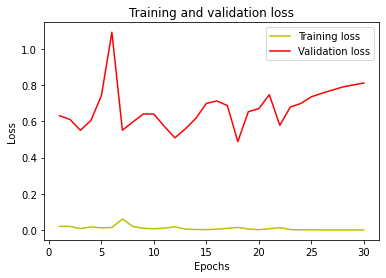

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

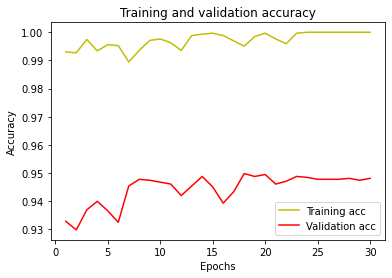

In [19]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

[[468  26   2   0   0   0]
 [  1 469   1   0   0   0]
 [  2   2 415   0   1   0]
 [  0   0   0 420  71   0]
 [  0   1   0  19 512   0]
 [  0   0   0   0  27 510]]
0.9480827960637936
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       496
           1       0.94      1.00      0.97       471
           2       0.99      0.99      0.99       420
           3       0.96      0.86      0.90       491
           4       0.84      0.96      0.90       532
           5       1.00      0.95      0.97       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



<AxesSubplot:>

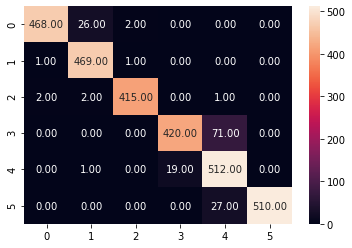

In [32]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=cnn3_model.predict([testX,testX,testX,testX])
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')